# Data Sources

Common data sources for predictive maintenance problems are :

* **Failure history:** The failure history of a machine or component within the machine.
* **Maintenance history:** The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
* **Machine conditions and usage:** The operating conditions of a machine e.g. data collected from sensors.
* **Machine features:** The features of a machine, e.g. engine size, make and model, location.
* **Operator features:** The features of the operator, e.g. gender, past experience
The data for this example comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age.

In [6]:
import pandas as pd

data_dir='data/'
telemetry = pd.read_csv(data_dir + 'PdM_telemetry.csv')
errors = pd.read_csv(data_dir + 'PdM_errors.csv')
maint = pd.read_csv(data_dir + 'PdM_maint.csv')
failures = pd.read_csv(data_dir + 'PdM_failures.csv')
machines = pd.read_csv(data_dir + 'PdM_machines.csv')

In [7]:
# format datetime field which comes in as string
# the standard deviation is a measure of the amount of variation or dispersion of a set of values.A low standard deviation indicates that the values tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the values are spread out over a wider range.

telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print("Total number of telemetry records: %d" % len(telemetry.index))
print(telemetry)
telemetry.describe()


Total number of telemetry records: 876100
                  datetime  machineID        volt      rotate    pressure  \
0      2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1      2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2      2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3      2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4      2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   
...                    ...        ...         ...         ...         ...   
876095 2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
876096 2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
876097 2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
876098 2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
876099 2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

        vibration  
0       45.08

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


#### **Telemetry**
The first data source is the telemetry time-series data which consists of **voltage, rotation, pressure, and vibration** measurements collected from 100 machines in **real time averaged over every hour collected during the year 2015**. Below, we display the first 10 records in the dataset. A summary of the whole dataset is also provided.

datetime        volt
0 2015-01-01 06:00:00  176.217853
1 2015-01-01 07:00:00  162.879223
2 2015-01-01 08:00:00  170.989902
3 2015-01-01 09:00:00  162.462833
4 2015-01-01 10:00:00  157.610021


Text(0.5, 0, 'Date')

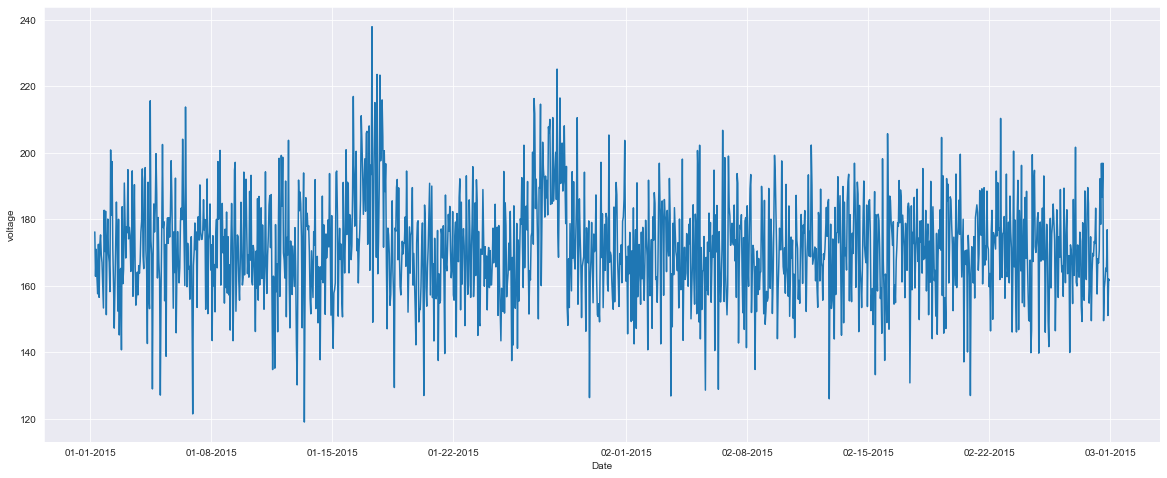

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#Access a group of rows and columns by label(s) or a boolean array.
plot_df = telemetry.loc[(telemetry['machineID'] == 1) & 
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) & 
                        (telemetry['datetime'] <pd.to_datetime('2015-03-01')),
                        ['datetime','volt']]

print(plot_df.head())
plot_df.describe()
sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
plt.plot(plot_df['datetime'], plot_df['volt'])
plt.ylabel('voltage')

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = '%m-%d-%Y'
plt.xlabel('Date')

#### **Errors**
The second major data source is the error logs. These are **non-breaking errors thrown while the machine is still operational and do not constitute as failures.** The **error date and times** are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [9]:
# format of datetime field which comes in as string
errors['datetime'] = pd.to_datetime(errors['datetime'],format = '%Y-%m-%d %H:%M:%S')
errors['errorID'] = errors['errorID'].astype('category')
print("Total Number of error records: %d" %len(errors.index))
print(errors.head())

Total Number of error records: 3919
             datetime  machineID errorID
0 2015-01-03 07:00:00          1  error1
1 2015-01-03 20:00:00          1  error3
2 2015-01-04 06:00:00          1  error5
3 2015-01-10 15:00:00          1  error4
4 2015-01-22 10:00:00          1  error4


error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

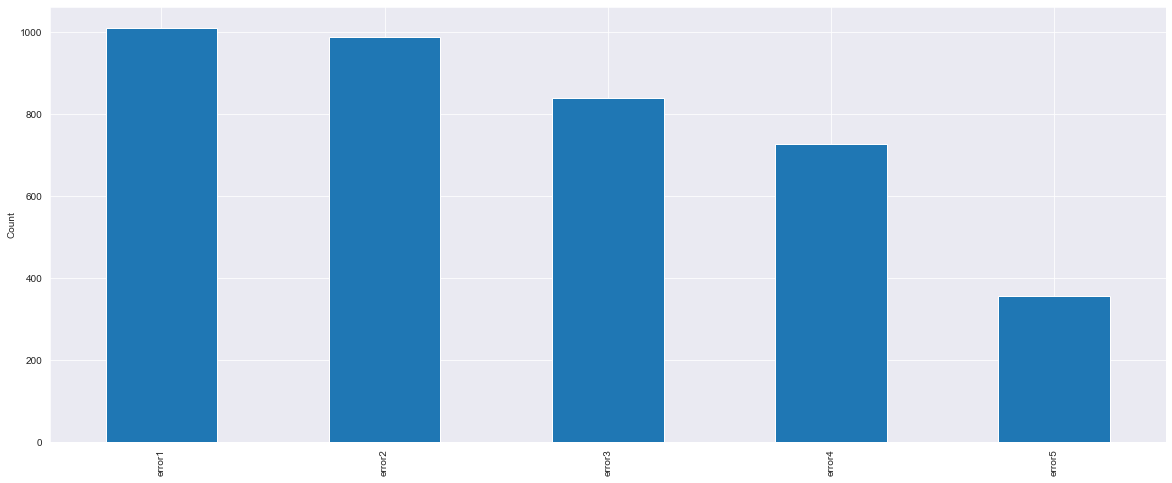

In [10]:
sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Count')
errors['errorID'].value_counts()

#### **Maintenance**
These are the **scheduled and unscheduled** maintenance records which correspond to both **regular inspection of components as well as failures.** A **record is generated if a component is replaced during the scheduled inspection or replaced due to a breakdown.** The **records that are created due to breakdowns will be called failures** which is explained in the later sections. Maintenance data has both 2014 and 2015 records.

In [11]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format='%Y-%m-%d %H:%M:%S')
maint['comp'] = maint['comp'].astype('category')
print("Total Number of maintenance Records: %d" %len(maint.index))
print(maint.head())

print(maint.value_counts())

Total Number of maintenance Records: 3286
             datetime  machineID   comp
0 2014-06-01 06:00:00          1  comp2
1 2014-07-16 06:00:00          1  comp4
2 2014-07-31 06:00:00          1  comp3
3 2014-12-13 06:00:00          1  comp1
4 2015-01-05 06:00:00          1  comp4
datetime             machineID  comp 
2016-01-01 06:00:00  78         comp3    1
2015-04-05 06:00:00  69         comp1    1
2015-04-06 06:00:00  42         comp3    1
                                comp2    1
                     35         comp3    1
                                        ..
2015-08-16 06:00:00  99         comp2    1
                     96         comp4    1
                     76         comp3    1
                     9          comp4    1
2014-06-01 06:00:00  1          comp2    1
Length: 3286, dtype: int64


comp2    863
comp4    811
comp3    808
comp1    804
Name: comp, dtype: int64

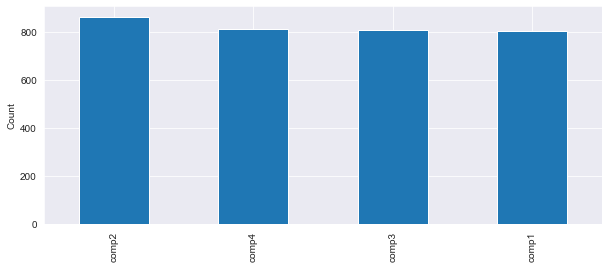

In [12]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 4))
maint['comp'].value_counts().plot(kind='bar')
plt.ylabel('Count')
maint['comp'].value_counts()

#### **Machines**
This data set includes some information about the machines: model type and age (years in service).

In [13]:
machines['model'] = machines['model'].astype('category')

print("Total number of machines: %d" % len(machines.index))
print(machines.head())
print(machines['model'].value_counts())

Total number of machines: 100
   machineID   model  age
0          1  model3   18
1          2  model4    7
2          3  model3    8
3          4  model3    7
4          5  model3    2
model3    35
model4    32
model2    17
model1    16
Name: model, dtype: int64


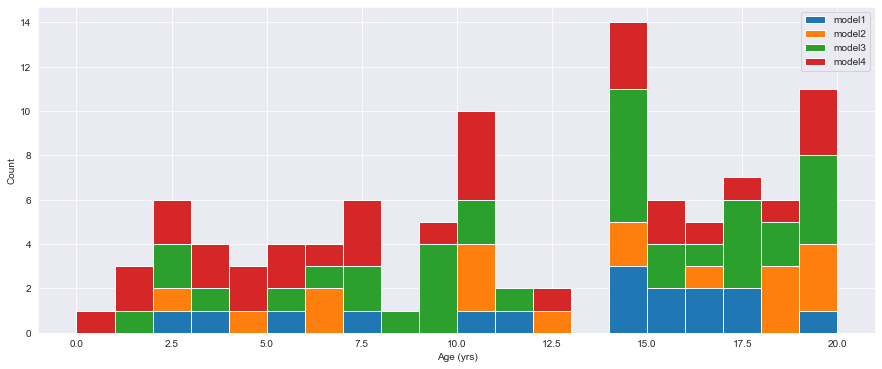

In [14]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()

#### **Failures**
These are the records of component replacements **due to failures.** Each record has a **date and time, machine ID, and failed component type.**

In [15]:
# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print("Total number of failures: %d" % len(failures.index))
#print(failures.value_counts())
print(failures['failure'].value_counts())
print(failures['machineID'].value_counts())
print(failures)

Total number of failures: 761
comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64
99     19
98     16
17     15
22     15
37     14
       ..
100     3
29      2
46      2
57      2
72      2
Name: machineID, Length: 98, dtype: int64
               datetime  machineID failure
0   2015-01-05 06:00:00          1   comp4
1   2015-03-06 06:00:00          1   comp1
2   2015-04-20 06:00:00          1   comp2
3   2015-06-19 06:00:00          1   comp4
4   2015-09-02 06:00:00          1   comp4
..                  ...        ...     ...
756 2015-11-29 06:00:00         99   comp3
757 2015-12-14 06:00:00         99   comp4
758 2015-02-12 06:00:00        100   comp1
759 2015-09-10 06:00:00        100   comp1
760 2015-12-09 06:00:00        100   comp2

[761 rows x 3 columns]


comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

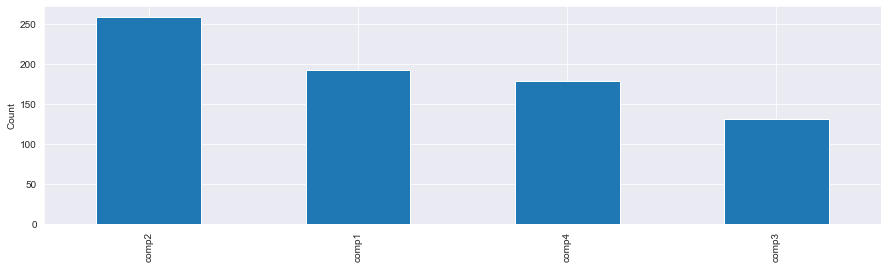

In [16]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')
failures['failure'].value_counts()

## Feature Engineering
The first step in predictive maintenance applications is feature engineering which requires bringing the different data sources together to create features that best describe a machines's health condition at a given point in time. In the next sections, several feature engineering methods are used to create features based on the properties of each data source.

### Lag Features from Telemetry
Telemetry data almost always comes with time-stamps which makes it suitable for calculating lagging features. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window. In the following, rolling mean and standard deviation of the telemetry data over the last 3 hour lag window is calculated for every 3 hours.

In [17]:
telemetry

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259


In [18]:
#columns: the column which the values will be aggregated on
pivot_df = pd.pivot_table(telemetry,
                index = 'datetime',
                columns = 'machineID',
                values = 'volt')
                
pivot_df.head()

machineID,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 06:00:00,176.217853,176.558913,185.482043,169.710847,165.082899,136.878588,156.006391,159.379320,223.853296,158.421261,...,177.688355,159.446409,154.356894,175.639054,201.977168,155.273542,143.613163,153.300953,168.596133,161.587466
2015-01-01 07:00:00,162.879223,158.282044,179.818516,180.186857,192.783995,154.396864,216.913502,152.349153,153.106118,174.631951,...,173.426162,189.422834,158.261613,166.829717,171.602257,147.249491,169.258107,171.471504,153.667693,163.333175
2015-01-01 08:00:00,170.989902,168.242028,165.616803,156.861991,159.702056,151.995695,175.150525,196.751468,208.751664,158.777566,...,157.582897,162.088177,167.533443,166.130186,178.198293,176.628231,162.714703,170.773931,178.319255,153.926056
2015-01-01 09:00:00,162.462833,180.280316,165.007013,170.282492,162.706162,172.820648,168.268241,171.170268,188.851492,178.128852,...,139.092689,174.951013,169.745685,169.926452,164.762482,183.274022,166.069217,165.851737,162.163821,174.653605
2015-01-01 10:00:00,157.610021,169.719531,138.898164,187.487332,166.158350,181.469455,171.786580,155.323747,214.927439,176.497316,...,156.584252,183.651525,171.956004,167.610602,163.891788,180.739105,167.869939,175.140637,180.201336,199.637542


In [19]:
#Downsample the series into 3 hours bins and sum the values of the timestamps falling into a bin.
pivot_df.resample('3H', closed='left', label='right').agg('mean')

machineID,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 09:00:00,170.028993,167.694328,176.972454,168.919898,172.522984,147.757049,182.690139,169.493314,195.237026,163.943592,...,169.565805,170.319140,160.050650,169.532985,183.925906,159.717088,158.528658,165.182129,166.861027,159.615566
2015-01-01 12:00:00,164.192565,180.419031,158.335330,170.170964,163.752781,164.163202,165.183285,175.984806,191.419434,168.266274,...,162.233275,182.693906,173.829574,169.941757,162.591156,184.434245,159.695671,166.887794,171.427877,184.748096
2015-01-01 15:00:00,168.134445,178.181316,159.266254,174.794830,183.687350,166.864158,175.786908,160.747287,167.800293,172.399917,...,175.151364,162.058766,170.448346,163.201680,190.438009,162.573535,175.085402,175.263339,160.045777,161.850332
2015-01-01 18:00:00,165.514453,172.819468,175.497495,155.885896,170.044798,168.653821,179.404746,167.720356,181.281871,176.205797,...,180.025605,165.466575,170.555552,155.303655,166.948809,175.967724,175.341739,179.742382,172.525338,179.727290
2015-01-01 21:00:00,168.809347,171.588752,171.272547,174.578644,169.457772,166.999611,171.849368,187.779835,177.233726,175.020379,...,175.999188,172.169763,168.066457,164.007219,181.428114,177.198419,175.009913,169.250730,170.348106,162.109000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 21:00:00,173.823921,169.192054,164.086899,172.863647,158.716841,176.026783,161.720422,167.078723,167.053187,164.434755,...,165.015234,172.865407,179.683580,171.598891,178.466219,161.886275,173.616305,158.904698,169.364259,166.078945
2016-01-01 00:00:00,159.011758,174.766302,180.413800,164.999091,155.306368,177.444907,156.685828,179.517195,149.464250,154.378577,...,150.720374,172.820016,169.554949,175.429910,165.857054,171.063273,162.092408,178.132093,163.702815,158.327984
2016-01-01 03:00:00,161.803419,184.791050,161.225563,163.972674,166.271876,163.546189,183.145084,175.205458,181.116531,166.044809,...,179.787844,177.732695,180.675454,166.312173,174.425937,170.823010,178.544789,173.540905,156.866569,170.306956


In [20]:
pivot_df.resample('3H', closed='left', label='right').agg('mean').unstack()

machineID  datetime           
1          2015-01-01 09:00:00    170.028993
           2015-01-01 12:00:00    164.192565
           2015-01-01 15:00:00    168.134445
           2015-01-01 18:00:00    165.514453
           2015-01-01 21:00:00    168.809347
                                     ...    
100        2015-12-31 21:00:00    166.078945
           2016-01-01 00:00:00    158.327984
           2016-01-01 03:00:00    170.306956
           2016-01-01 06:00:00    182.525427
           2016-01-01 09:00:00    171.336037
Length: 292100, dtype: float64

In [21]:
# Calculate mean values for telemetry features
# maybe there is a need for .tail().dropna()
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').agg('mean').unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)
telemetry_mean_3h

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542
...,...,...,...,...,...,...
292095,100,2015-12-31 21:00:00,166.078945,424.431184,98.344409,30.907459
292096,100,2016-01-01 00:00:00,158.327984,504.056262,108.055441,40.109705
292097,100,2016-01-01 03:00:00,170.306956,438.653616,102.346227,47.481232
292098,100,2016-01-01 06:00:00,182.525427,435.932056,98.798172,42.757630


In [22]:
# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').agg('std').unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_sd_3h

,machineID,datetime,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h
0,1,2015-01-01 09:00:00,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,10.124584,55.084734,5.909721,5.169304
3,1,2015-01-01 18:00:00,4.673269,42.047278,4.554047,2.106108
4,1,2015-01-01 21:00:00,14.752132,47.048609,4.244158,2.207884
...,...,...,...,...,...,...
292095,100,2015-12-31 21:00:00,29.351231,69.348245,16.940674,3.731256
292096,100,2016-01-01 00:00:00,9.605817,78.036116,9.154932,3.379639
292097,100,2016-01-01 03:00:00,8.457322,43.021553,0.785721,3.198928
292098,100,2016-01-01 06:00:00,14.835200,19.208302,5.002788,6.836757



For capturing a longer term effect, 24 hour lag features are also calculated as below.

In [23]:
#.tail().dropna() maybe needed after agg
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    rmean=pd.pivot_table(telemetry,
                                    index='datetime',
                                    columns='machineID',
                                    values=col)
                                    
    temp.append(rmean.rolling(24).mean().resample('3H',
                                                    closed='left',
                                                    label='right').agg('first').unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]
# Notice that a 24h rolling average is not available at the earliest timepoints
telemetry_mean_24h

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
11,1,2015-01-02 18:00:00,170.792486,448.440437,95.766838,40.055214
...,...,...,...,...,...,...
292095,100,2015-12-31 21:00:00,171.547643,452.351565,101.789714,39.184285
292096,100,2016-01-01 00:00:00,168.806645,459.502212,100.919285,38.150193
292097,100,2016-01-01 03:00:00,169.011763,465.923073,101.568092,39.456302
292098,100,2016-01-01 06:00:00,172.838745,461.095362,101.396728,39.964090


In [24]:
# repeat for standard deviation
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    pivot = pd.pivot_table(telemetry,
                                    index='datetime',
                                    columns='machineID',
                                    values=col)
    # Append rows of other to the end of caller, returning a new object.
    temp.append(pivot.rolling(24).std().resample('3H',
                                                    closed='left',
                                                    label='right').agg('first').unstack())
# Concatenate pandas objects along a particular axis with optional set logic along the other axes.
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
# Access a group of rows and columns by label(s) or a boolean array.
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h

,machineID,datetime,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
0,1,2015-01-02 06:00:00,11.233120,48.717395,10.079880,5.853209
1,1,2015-01-02 09:00:00,12.519402,48.385076,10.171540,6.163231
2,1,2015-01-02 12:00:00,13.370357,42.432317,9.471669,6.195076
3,1,2015-01-02 15:00:00,13.299281,41.346121,8.731229,5.687944
4,1,2015-01-02 18:00:00,13.954518,43.490234,8.061653,5.898069
...,...,...,...,...,...,...
291395,100,2015-12-31 21:00:00,16.429023,62.147934,7.475540,5.448962
291396,100,2016-01-01 00:00:00,17.019808,64.730136,8.961444,5.833191
291397,100,2016-01-01 03:00:00,17.096392,64.718132,9.420879,5.738756
291398,100,2016-01-01 06:00:00,15.119775,65.929509,8.836617,6.139142


Next, the columns of the feature datasets created earlier are merged to create the final feature set from telemetry.

In [25]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.iloc[:,  2:6],
                            telemetry_mean_24h.iloc[:, 2:6],
                            telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,15.726970,39.648116,11.904700,5.601191
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,15.635083,41.828592,11.326412,5.583521
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.995465,40.843882,11.036546,5.561553
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.100364,43.409841,10.972862,6.068674
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.808489,43.742304,10.988704,7.286129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291395,100,2015-10-05 09:00:00,188.267556,407.256175,108.931184,36.553233,9.599915,40.722980,1.639521,5.724500,171.826650,441.278667,98.311919,39.196175,16.429023,62.147934,7.475540,5.448962
291396,100,2015-10-05 12:00:00,167.859576,465.992407,107.953155,42.708899,14.190347,92.277799,9.577243,0.735339,174.657123,444.147310,98.520388,38.820190,17.019808,64.730136,8.961444,5.833191
291397,100,2015-10-05 15:00:00,170.348099,434.234744,104.514343,38.607950,10.232598,49.524471,12.445345,2.596743,173.787879,448.842085,100.028549,39.375067,17.096392,64.718132,9.420879,5.738756
291398,100,2015-10-05 18:00:00,152.265370,459.557611,103.536524,40.718426,6.758667,27.051145,12.824247,2.752883,172.496791,442.086577,100.361794,38.943434,15.119775,65.929509,8.836617,6.139142


### Lag Features from Errors
Like telemetry data, errors come with timestamps. An important difference is that the **error IDs are categorical values** and **should not be averaged over time intervals like the telemetry measurements.** Instead, we count the number of errors of each type in a **lagging window. We begin by reformatting the error data** to have one entry per machine per time at which at least one error occurred:

In [26]:
errors

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
...,...,...,...
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3


In [27]:
# create a column for each error type
# Convert categorical variable into dummy/indicator variables.
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
error_count.head(13)

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-03 07:00:00,1,1,0,0,0,0
1,2015-01-03 20:00:00,1,0,0,1,0,0
2,2015-01-04 06:00:00,1,0,0,0,0,1
3,2015-01-10 15:00:00,1,0,0,0,1,0
4,2015-01-22 10:00:00,1,0,0,0,1,0
5,2015-01-25 15:00:00,1,0,0,0,1,0
6,2015-01-27 04:00:00,1,1,0,0,0,0
7,2015-03-03 22:00:00,1,0,1,0,0,0
8,2015-03-05 06:00:00,1,1,0,0,0,0
9,2015-03-20 18:00:00,1,1,0,0,0,0


In [28]:
# Group DataFrame using a mapper or by a Series of columns.
# A groupby operation involves some combination of splitting the object, applying a function, and combining the results. This can be used to group large amounts of data and compute operations on these groups.
# combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID','datetime']).sum().reset_index()
error_count.head(13)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
5,1,2015-01-25 15:00:00,0,0,0,1,0
6,1,2015-01-27 04:00:00,1,0,0,0,0
7,1,2015-03-03 22:00:00,0,1,0,0,0
8,1,2015-03-05 06:00:00,1,0,0,0,0
9,1,2015-03-20 18:00:00,1,0,0,0,0


In [29]:
#Merge DataFrame or named Series objects with a database-style join.
#The join is done on columns or indexes. If joining columns on columns, the DataFrame indexes will be ignored. Otherwise if joining indexes on indexes or indexes on a column or columns, the index will be passed on.

error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,0.0,0.0,0.0,0.0,0.0
876096,2016-01-01 03:00:00,100,0.0,0.0,0.0,0.0,0.0
876097,2016-01-01 04:00:00,100,0.0,0.0,0.0,0.0,0.0
876098,2016-01-01 05:00:00,100,0.0,0.0,0.0,0.0,0.0


Finally, we can compute the total number of errors of each type over the last 24 hours, for timepoints taken every three hours:

In [30]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    pivot = pd.pivot_table(error_count,
                                        index='datetime',
                                        columns='machineID',
                                        values=col)
    temp.append(pivot.rolling(24).sum().resample('3H',
                                                closed='left',
                                                label='right').agg('first').unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
#Remove missing values.
error_count = error_count.dropna()
error_count

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
292095,100,2015-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0
292096,100,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0
292097,100,2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0
292098,100,2016-01-01 06:00:00,0.0,0.0,0.0,0.0,0.0


### Days Since Last Replacement from Maintenance
A crucial data set in this example is the maintenance records which contain the information of component replacement records. Possible features from this data set can be, for example, the number of replacements of each component in the last 3 months to incorporate the frequency of replacements. However, more relevent information would be to calculate how long it has been since a component is last replaced as that would be expected to correlate better with component failures since the longer a component is used, the more degradation should be expected.

As a side note, creating lagging features from maintenance data is not as straightforward as for telemetry and errors, so the features from this data are generated in a more custom way. This type of ad-hoc feature engineering is very common in predictive maintenance since domain knowledge plays a big role in understanding the predictors of a problem. In the following, the days since last component replacement are calculated for each component type as features from the maintenance data.

In [32]:
import numpy as np

# create a column for each error type
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# replace dates of most recent component change with days since most recent component change
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')
    
comp_rep

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667
...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,82.833333,7.833333,82.833333,52.833333
876096,2016-01-01 03:00:00,100,82.875000,7.875000,82.875000,52.875000
876097,2016-01-01 04:00:00,100,82.916667,7.916667,82.916667,52.916667
876098,2016-01-01 05:00:00,100,82.958333,7.958333,82.958333,52.958333


## Machine Features
The machine features can be used without further modification. These include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

Lastly, we merge all the feature data sets we created earlier to get the final feature matrix.

In [33]:
telemetry_feat

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,15.726970,39.648116,11.904700,5.601191
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,15.635083,41.828592,11.326412,5.583521
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.995465,40.843882,11.036546,5.561553
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.100364,43.409841,10.972862,6.068674
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.808489,43.742304,10.988704,7.286129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291395,100,2015-10-05 09:00:00,188.267556,407.256175,108.931184,36.553233,9.599915,40.722980,1.639521,5.724500,171.826650,441.278667,98.311919,39.196175,16.429023,62.147934,7.475540,5.448962
291396,100,2015-10-05 12:00:00,167.859576,465.992407,107.953155,42.708899,14.190347,92.277799,9.577243,0.735339,174.657123,444.147310,98.520388,38.820190,17.019808,64.730136,8.961444,5.833191
291397,100,2015-10-05 15:00:00,170.348099,434.234744,104.514343,38.607950,10.232598,49.524471,12.445345,2.596743,173.787879,448.842085,100.028549,39.375067,17.096392,64.718132,9.420879,5.738756
291398,100,2015-10-05 18:00:00,152.265370,459.557611,103.536524,40.718426,6.758667,27.051145,12.824247,2.752883,172.496791,442.086577,100.361794,38.943434,15.119775,65.929509,8.836617,6.139142


In [34]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

print(final_feat.head())
final_feat

machineID            datetime  voltmean_3h  rotatemean_3h  pressuremean_3h  \
0          1 2015-01-02 06:00:00   180.133784     440.608320        94.137969   
1          1 2015-01-02 09:00:00   176.364293     439.349655       101.553209   
2          1 2015-01-02 12:00:00   160.384568     424.385316        99.598722   
3          1 2015-01-02 15:00:00   170.472461     442.933997       102.380586   
4          1 2015-01-02 18:00:00   163.263806     468.937558       102.726648   

   vibrationmean_3h  voltsd_3h  rotatesd_3h  pressuresd_3h  vibrationsd_3h  \
0         41.551544  21.322735    48.770512       2.135684       10.037208   
1         36.105580  18.952210    51.329636      13.789279        6.737739   
2         36.094637  13.047080    13.702496       9.988609        1.639962   
3         40.483002  16.642354    56.290447       3.305739        8.854145   
4         40.921802  17.424688    38.680380       9.105775        3.060781   

   ...  error2count  error3count  error4count  

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290596,100,2015-10-05 09:00:00,188.267556,407.256175,108.931184,36.553233,9.599915,40.722980,1.639521,5.724500,...,0.0,0.0,0.0,0.0,10.125,70.125,55.125,40.125,model4,5
290597,100,2015-10-05 12:00:00,167.859576,465.992407,107.953155,42.708899,14.190347,92.277799,9.577243,0.735339,...,0.0,0.0,0.0,0.0,10.250,70.250,55.250,40.250,model4,5
290598,100,2015-10-05 15:00:00,170.348099,434.234744,104.514343,38.607950,10.232598,49.524471,12.445345,2.596743,...,0.0,0.0,0.0,0.0,10.375,70.375,55.375,40.375,model4,5
290599,100,2015-10-05 18:00:00,152.265370,459.557611,103.536524,40.718426,6.758667,27.051145,12.824247,2.752883,...,0.0,0.0,0.0,0.0,10.500,70.500,55.500,40.500,model4,5


# Label Construction
When using multi-class classification for predicting failure due to a problem, labelling is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "about to fail due to a problem" while labelling all other records as "Â€Âœnormal." This time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be needed to allow e.g. for arrival of replacement parts.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4). Below, a categorical failure feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have failure=comp1, and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have failure=none.

In [35]:
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.bfill(axis=1, limit=7) # fill backward up to 24h
labeled_features = labeled_features.fillna('none')
labeled_features.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,none


Below is an example of records that are labeled as failure=comp4 in the failure column. Notice that the first 8 records all occur in the 24-hour window before the first recorded failure of component 4. The next 8 records are within the 24 hour window before another failure of component 4.

In [36]:
labeled_features.loc[labeled_features['failure'] == 'comp4'][:16]
labeled_features

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290637,100,2015-10-05 09:00:00,188.267556,407.256175,108.931184,36.553233,9.599915,40.722980,1.639521,5.724500,...,0.0,0.0,0.0,10.125,70.125,55.125,40.125,model4,5,none
290638,100,2015-10-05 12:00:00,167.859576,465.992407,107.953155,42.708899,14.190347,92.277799,9.577243,0.735339,...,0.0,0.0,0.0,10.250,70.250,55.250,40.250,model4,5,none
290639,100,2015-10-05 15:00:00,170.348099,434.234744,104.514343,38.607950,10.232598,49.524471,12.445345,2.596743,...,0.0,0.0,0.0,10.375,70.375,55.375,40.375,model4,5,none
290640,100,2015-10-05 18:00:00,152.265370,459.557611,103.536524,40.718426,6.758667,27.051145,12.824247,2.752883,...,0.0,0.0,0.0,10.500,70.500,55.500,40.500,model4,5,none


In [1]:
compression_opts = dict(method='zip',
                        archive_name='full.csv')  
labeled_features.to_csv('full.zip', index=False,
          compression=compression_opts)

NameError: name 'labeled_features' is not defined

# Modelling
After the feature engineering and labelling steps, either Azure Machine Learning Studio or this notebook can be used to create a predictive model. The recommend Azure Machine Learning Studio experiment can be found in the Cortana Intelligence Gallery: Predictive Maintenance Modelling Guide Experiment. Below, we describe the modelling process and provide an example Python model.

# Training, Validation and Testing
When working with time-stamped data as in this example, record partitioning into training, validation, and test sets should be performed carefully to prevent overestimating the performance of the models. In predictive maintenance, the features are usually generated using lagging aggregates: records in the same time window will likely have identical labels and similar feature values. These correlations can give a model an "unfair advantage" when predicting on a test set record that shares its time window with a training set record. We therefore partition records into training, validation, and test sets in large chunks, to minimize the number of time intervals shared between them.

Predictive models have no advance knowledge of future chronological trends: in practice, such trends are likely to exist and to adversely impact the model's performance. To obtain an accurate assessment of a predictive model's performance, we recommend training on older records and validating/testing using newer records.

For both of these reasons, a time-dependent record splitting strategy is an excellent choice for predictive maintenace models. The split is effected by choosing a point in time based on the desired size of the training and test sets: all records before the timepoint are used for training the model, and all remaining records are used for testing. (If desired, the timeline could be further divided to create validation sets for parameter selection.) To prevent any records in the training set from sharing time windows with the records in the test set, we remove any records at the boundary -- in this case, by ignoring 24 hours' worth of data prior to the timepoint.

In [37]:
    from sklearn.ensemble import GradientBoostingClassifier

    # make test and training splits
    threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                    [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                    [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

    test_results = []
    models = []
    for last_train_date, first_test_date in threshold_dates:
        # split out training and test data
        train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
        train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                            'machineID',
                                                                                                            'failure'], 1))
        test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], 1))
        # train and predict using the model, storing results for later
        my_model = GradientBoostingClassifier(random_state=42)
        my_model.fit(train_X, train_y)
        test_result = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
        test_result['predicted_failure'] = my_model.predict(test_X)
        test_results.append(test_result)
        models.append(my_model)

Text(0, 0.5, 'Importance')

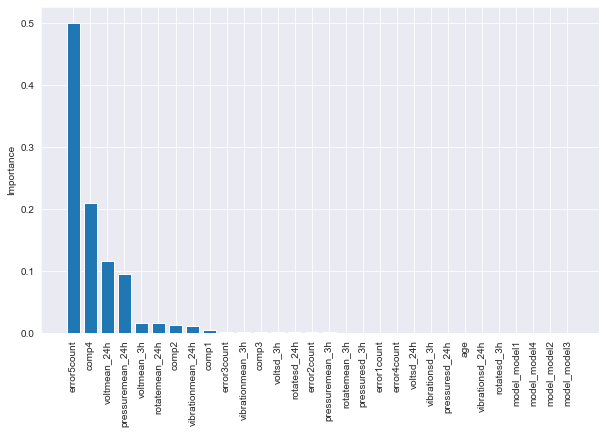

In [38]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

# Evaluation
In predictive maintenance, machine failures are usually rare occurrences in the lifetime of the assets compared to normal operation. This causes an imbalance in the label distribution which usually causes poor performance as algorithms tend to classify majority class examples better at the expense of minority class examples as the total misclassification error is much improved when majority class is labeled correctly. This causes low recall rates although accuracy can be high and becomes a larger problem when the cost of false alarms to the business is very high. To help with this problem, sampling techniques such as oversampling of the minority examples are usually used along with more sophisticated techniques which are not covered in this notebook.

Text(0, 0.5, 'Count')

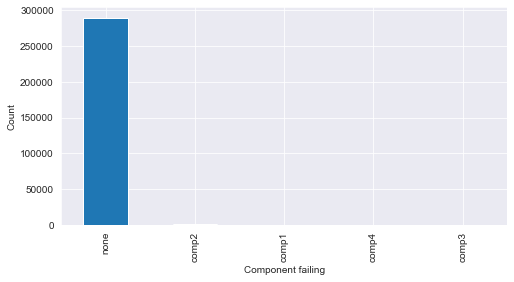

In [39]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
labeled_features['failure'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')

Also, due to the class imbalance problem, it is important to look at evaluation metrics other than accuracy alone and compare those metrics to the baseline metrics which are computed when random chance is used to make predictions rather than a machine learning model. The comparison will bring out the value and benefits of using a machine learning model better.

In the following, we use an evaluation function that computes many important evaluation metrics along with baseline metrics for classification problems. For a detailed explanation of the metrics, please refer to the scikit-learn documentation and a companion blog post (with examples in R, not Python),

In [40]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df

In [41]:
evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i+1))
    evaluation_result = Evaluate(actual = test_result['failure'],
                                 predicted = test_result['predicted_failure'],
                                 labels = ['none', 'comp1', 'comp2', 'comp3', 'comp4'])
    evaluation_results.append(evaluation_result)
evaluation_results[0]  # show full results for first split only


Split 1:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[121582     15     10     11      0]
 [     6     49      3      6      2]
 [     0     19     91      1      0]
 [     0      1      2     49      0]
 [     1     70      0      0      2]]

Split 2:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[    1   164   846 95864     1]
 [    1    38     4     6     2]
 [    0     1    85     4     0]
 [    0     0     2    37     1]
 [    3     0     0    54     0]]

Split 3:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[72918    11     1     0     1]
 [    1    34     2     0     2]
 [   50     6     9     5     1]
 [    3    13     0    11     1]
 [    9     4     0     0    28]]


,none,comp1,comp2,comp3,comp4
accuracy,0.998794,0.998794,0.998794,0.998794,0.998794
precision,0.999942,0.318182,0.858491,0.731343,0.500000
recall,0.999704,0.742424,0.819820,0.942308,0.027397
F1,0.999823,0.445455,0.838710,0.823529,0.051948
macro precision,0.681592,0.681592,0.681592,0.681592,0.681592
macro recall,0.706331,0.706331,0.706331,0.706331,0.706331
macro F1,0.631893,0.631893,0.631893,0.631893,0.631893
average accuracy,0.999518,0.999518,0.999518,0.999518,0.999518
micro-averaged precision/recall/F1,0.998794,0.998794,0.998794,0.998794,0.998794
majority class accuracy,0.997523,0.000000,0.000000,0.000000,0.000000
